# Proyecto Final: Particle Image Velocimetry
## Por Didier Muñoz Díaz

In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot
from numba import jit
import tqdm

#### Iniciamos cargando desde el disco dos imágenes

In [3]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img2 = img.convert("L")
    data = np.asarray( img2, dtype="float64" )

    return data

In [5]:
#img1 = load_image("imgs/img1.png")
#img2 = load_image("imgs/img2.png")
calibration = pyplot.imread("./PIV_DATA/calibration/calibration.tif")
imgs = pyplot.imread("./PIV_DATA/15deg/B00001.tif")
print(imgs.shape)
img1 = (imgs[:imgs.shape[0]//2,:])/imgs.max()
img2 = (imgs[imgs.shape[0]//2:,:])/imgs.max()




img1 -= int(np.mean(img1)) 
img2 -= int(np.mean(img2))
# img2 = img2-img1

fig=pyplot.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
pyplot.imshow(img1, aspect='equal')
fig.add_subplot(1, 2, 2)
pyplot.imshow(img2, aspect='equal')
# pyplot.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Rec\\UniStuff\\MSc\\AE4180_FlowMeasTech\\AE4180_FMT\\piv_code\\PIV_DATA\\calibration\\calibration.tif'

#### Posteriormente necesitamos dividir las dos imágenes en zonas de interrogación

In [131]:
# @jit
def split_image(img, zones_w, zones_h):
    v_split_points = np.arange(start=0, stop=len(img), step=zones_h)
    v_pieces = np.vsplit(img, v_split_points[1:])
    h_split_points = np.arange(start=0, stop=len(img[0]), step=zones_w)
    pieces = list()
    for r in v_pieces:
        pieces_row = np.hsplit(r, h_split_points[1:])
        pieces = pieces + pieces_row
    return pieces, len(v_pieces), len(pieces_row)

# @jit
def plot_pieces(pieces, rows, cols, arrows_coords = None):
    fig_gas=pyplot.figure(figsize=(15, 10))
    for i in range(0, rows*cols):
        ax = fig_gas.add_subplot(rows, cols, i+1)
        ax.axis("off")
        pyplot.imshow(pieces[i], aspect="equal")
        if arrows_coords != None:
            pyplot.annotate("", xy=arrows_coords[2*i+1], xytext=arrows_coords[2*i], 
                                arrowprops=dict(arrowstyle="->", color="orange", lw=3.))
    pyplot.tight_layout()
    pyplot.show()

In [132]:
int_zones_w = 20 #22
int_zones_h = 20 #22
img1_int_zones, p_rows, p_cols = split_image(img1, int_zones_w, int_zones_h)
img2_int_zones, p_rows, p_cols = split_image(img2, int_zones_w, int_zones_h)
# plot_pieces(img1_int_zones, p_rows, p_cols)

#### Ya con las zonas de interrogación, lo que sigue es calcular el desplazamiento promedio de las partículas en cada zona de interrogación

Primero definimos cómo calcular eficientemente la correlación cruzada de dos imágenes utilizando la transformada rápida de Fourier

In [133]:
# @jit
def fft_correlation(zone0, zone1):
    zone0_fft = np.fft.rfft2(zone0, norm='ortho')
    zone1_fft = np.fft.rfft2(zone1, norm='ortho')
    fft_mult = np.conjugate(zone0_fft) * zone1_fft
    corr = np.fft.irfft2(fft_mult, s=zone0.shape, norm='ortho')
    corr[0][0] = 0.
    return corr

# @jit
def compute_correlation_maps(zones1, zones2):
    correlation_maps = list()
    for i in range(len(zones1)):
        corr = fft_correlation(zones1[i], zones2[i])
        correlation_maps.append(corr)
    return correlation_maps

Luego, ya teniendo los mapas de correlación (uno por cada zona de interrogación) necesitamos obtener el desplazamiento a partir del máximo del mapa de correlación

In [134]:
# @jit
def get_maximums_displacements(corr_maps):
    idx_lst = list()
    for k in range(len(corr_maps)):
        flat_idx = np.argmax(corr_maps[k])
        z_w = corr_maps[k].shape[0]
        z_h = corr_maps[k].shape[1]
        calto = z_h % 2
        cancho = z_w % 2
        i = flat_idx // z_w
        j = flat_idx % z_w
        if(i<=z_h//2):
            y = i-1+calto
        else:
            y = i-1-z_h+calto
        if(j <= z_w//2):
            x = j-1+cancho
        else:
            x = j-1-z_w+cancho
        idx_lst.append(np.array([x, y]))
    return idx_lst

Ya con los desplazamientos, sólo falta mostrar los resultados

In [135]:
# We need to transform each displacement to make the arrows start in the center of the region
def get_arrows_coordinates(idx_lst, corr_maps):
    coords_lst = list()
    
    for i in range(len(idx_lst)):
        coords_lst.append(np.asarray(corr_maps[i].shape) // 2)
        coords_lst.append((np.asarray(corr_maps[i].shape) // 2) + (idx_lst[i]))
    return coords_lst
            
def plot_image_witharrows(img, displ, w, h, filename=None, annotate_arrow = False):
    fig = pyplot.figure(figsize=(15, 15))
    pyplot.imshow(img, aspect='equal')
    cols = img.shape[1] // w
    cols_r = (img.shape[1] % w) // 2
    rows = img.shape[0] // h
    rows_r = (img.shape[0] % h) // 2
    k = 0
    l = 0
    ij = np.array( [w//2, h//2] )
    for d in tqdm.tqdm(displ):
        if annotate_arrow:
            pyplot.annotate("", xy=d+ij, xytext=ij, 
                            arrowprops=dict(arrowstyle="->", color="orange", lw=1.))
        l = l+1
        if(l<cols): 
            ij[0] = (l*w) + (w//2)
        if(l==cols): 
            ij[0] = l*w + cols_r
        if(l > cols):
            ij[0] = w//2
            l = 0
            k = k+1
            if( k < rows):
                ij[1] = k*h + (h//2)
            if k==rows:
                ij[1] = k*h + (rows_r)
    pyplot.show()
    if(filename != None):
        pyplot.savefig(filename, bbox_inches='tight')    

El orden de ejecución de las funciones anteriores es el siguiente:
- Obtener mapas de correlación

In [136]:
corr_maps = compute_correlation_maps(img1_int_zones, img2_int_zones)

- Obtener los desplazamientos a partir de los máximos

In [137]:
max_idxs = get_maximums_displacements(corr_maps)

- Calcular las coordenadas para pintar las flechas que indican el desplazamiento de cada zona de interrogación

In [138]:
arrow_coords = get_arrows_coordinates(max_idxs, corr_maps)

###### Los mapas de correlación

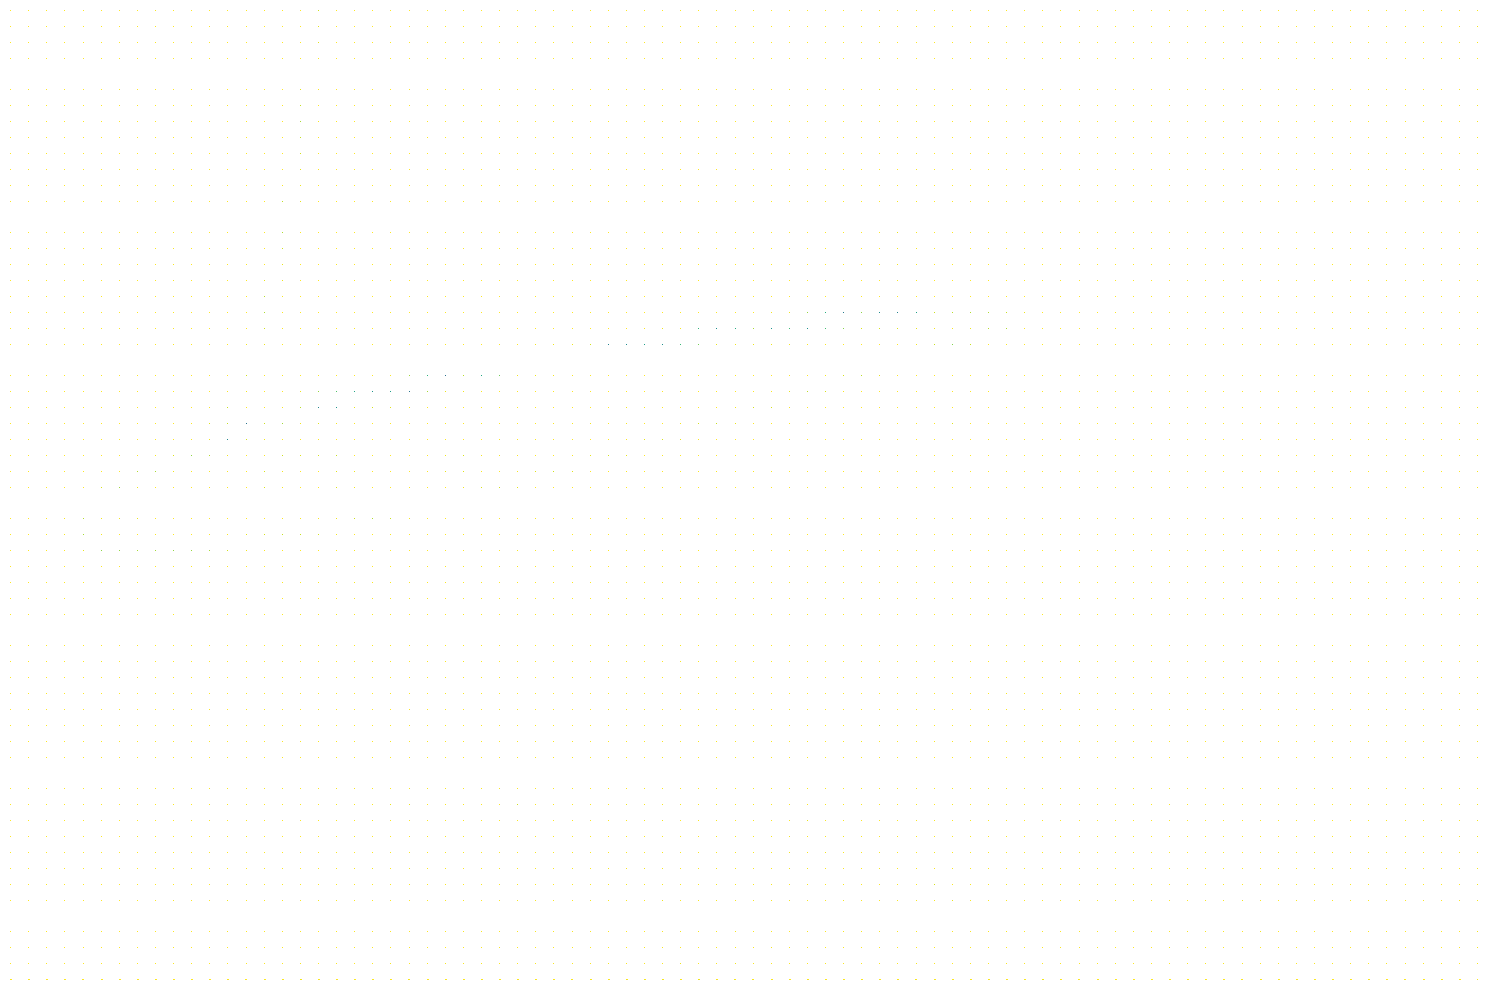

In [142]:
plot_pieces(corr_maps, p_rows, p_cols)

###### Los desplazamientos en cada zona de interrogación

In [140]:
# plot_pieces(img1_int_zones, p_rows, p_cols, arrow_coords)

  0%|          | 0/5084 [00:00<?, ?it/s]

100%|██████████| 5084/5084 [00:00<00:00, 8103.36it/s]


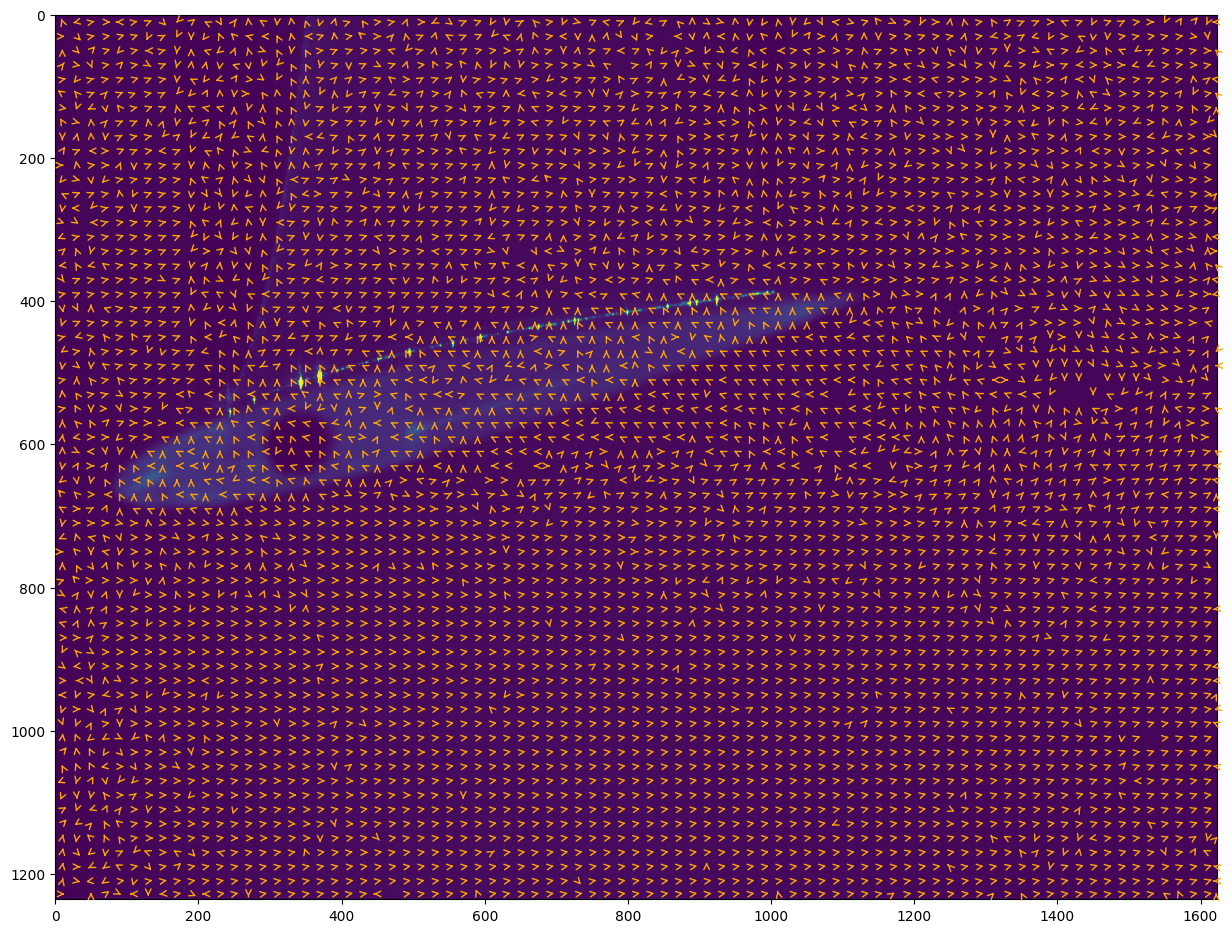

In [141]:
plot_image_witharrows(img1, max_idxs, int_zones_w, int_zones_h,annotate_arrow=True)